In [2]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import scanpy as sc
import decoupler as dc
import pandas as pd
import numpy as np
from loguru import logger

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('/home/mowp/workspace/mowp_scripts/tools')

import os
os.environ['R_HOME'] = '/home/mowp/mambaforge/envs/sc/lib/R'

import sctk

In [14]:
infile = '/data/user/mowp/data/scRNA/cscc.h5ad'
adata = sc.read_h5ad(infile)
adata

AnnData object with n_obs × n_vars = 163964 × 29225
    obs: 'sample', 'patient', 'group', 'ihc_group', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'tumor', 'cell_type_l0', 'tumor_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'cell_type_l0_colors', 'cell_type_l1_colors', 'cell_type_l2_colors', 'cell_type_l3_colors', 'group_colors', 'highly_variable_method', 'hvg', 'ihc_group_colors', 'n_top_genes', 'sample_colors', 'umap', 'x_dtype'
    obsm: 'X_pca', 'X_umap'

In [15]:
adata.obs

,sample,patient,group,ihc_group,cell_type_l2,cell_type_l1,cell_type_l3,tumor,cell_type_l0,tumor_celltype
AAACCCACAAACACCT-1-0,CC01,CC01,CSCC,Excluded/Desert,CD4 T,T,CD4_Treg FOXP3,N,immune,not applied
AAACCCACAACTCCCT-1-0,CC01,CC01,CSCC,Excluded/Desert,CD4 T,T,CD4_Treg FOXP3,N,immune,not applied
AAACCCACACGACAGA-1-0,CC01,CC01,CSCC,Excluded/Desert,B,B,Naive B cells,N,immune,not applied
AAACCCAGTGGAACCA-1-0,CC01,CC01,CSCC,Excluded/Desert,B,B,Memory B cells,N,immune,not applied
AAACCCATCCCTCAAC-1-0,CC01,CC01,CSCC,Excluded/Desert,NK,NK,NK KLRC3,N,immune,not applied
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAACCGATT-1-18,HD03,HD03,HD,not applied,Glandular,Glandular,Glandular,N,epi,not applied
TTTGTTGCACCGGTCA-1-18,HD03,HD03,HD,not applied,Myocyte,Myocyte,Myocyte_PLN,N,stromal,not applied
TTTGTTGCAGCCTACG-1-18,HD03,HD03,HD,not applied,Glandular,Glandular,Glandular,N,epi,not applied
TTTGTTGCAGGTAGTG-1-18,HD03,HD03,HD,not applied,Fibroblast,Fibroblast,Fibroblast_ID2,N,stromal,not applied


In [18]:
adata.obs['sample'].cat.categories

Index(['CC01', 'CC02', 'CC03', 'CC04', 'CC05', 'CC06', 'CC07', 'CC08', 'CC09',
       'CC10', 'CC11', 'CC12', 'CC13', 'CC14', 'HD01', 'HD02', 'HD03'],
      dtype='object')

In [19]:
adata.obs['group'].cat.categories

Index(['CSCC', 'HD'], dtype='object')

In [25]:
samples = list(adata.obs['sample'].cat.categories)
cscc = list(filter(lambda x: x.startswith("CC"), samples))
hd = list(filter(lambda x: x.startswith("HD"), samples))

# 对样品进行分组
subgroups = {
    'CSCC': cscc,
    'HD': hd
}

subgroups

{'CSCC': ['CC01',
  'CC02',
  'CC03',
  'CC04',
  'CC05',
  'CC06',
  'CC07',
  'CC08',
  'CC09',
  'CC10',
  'CC11',
  'CC12',
  'CC13',
  'CC14'],
 'HD': ['HD01', 'HD02', 'HD03']}

In [21]:
adata.obs['cell_type_l1'].cat.categories

Index(['T', 'NK', 'B', 'Myeloid', 'Fibroblast', 'Myocyte', 'Endothelial',
       'Glandular', 'Squamous'],
      dtype='object')

In [22]:
# 对细胞类型进行分组
subkeys = {
    'immune': ['T', 'NK', 'B', 'Myeloid', 'Myocyte'],
    'non-immune': ['Fibroblast', 'Endothelial', 'Glandular', 'Squamous']
}

2024-05-27 20:03:36.527 | DEBUG    | sctk.pl.plotcluster:_plot_grouped_bars:250 - width_ratios=[14, 3]


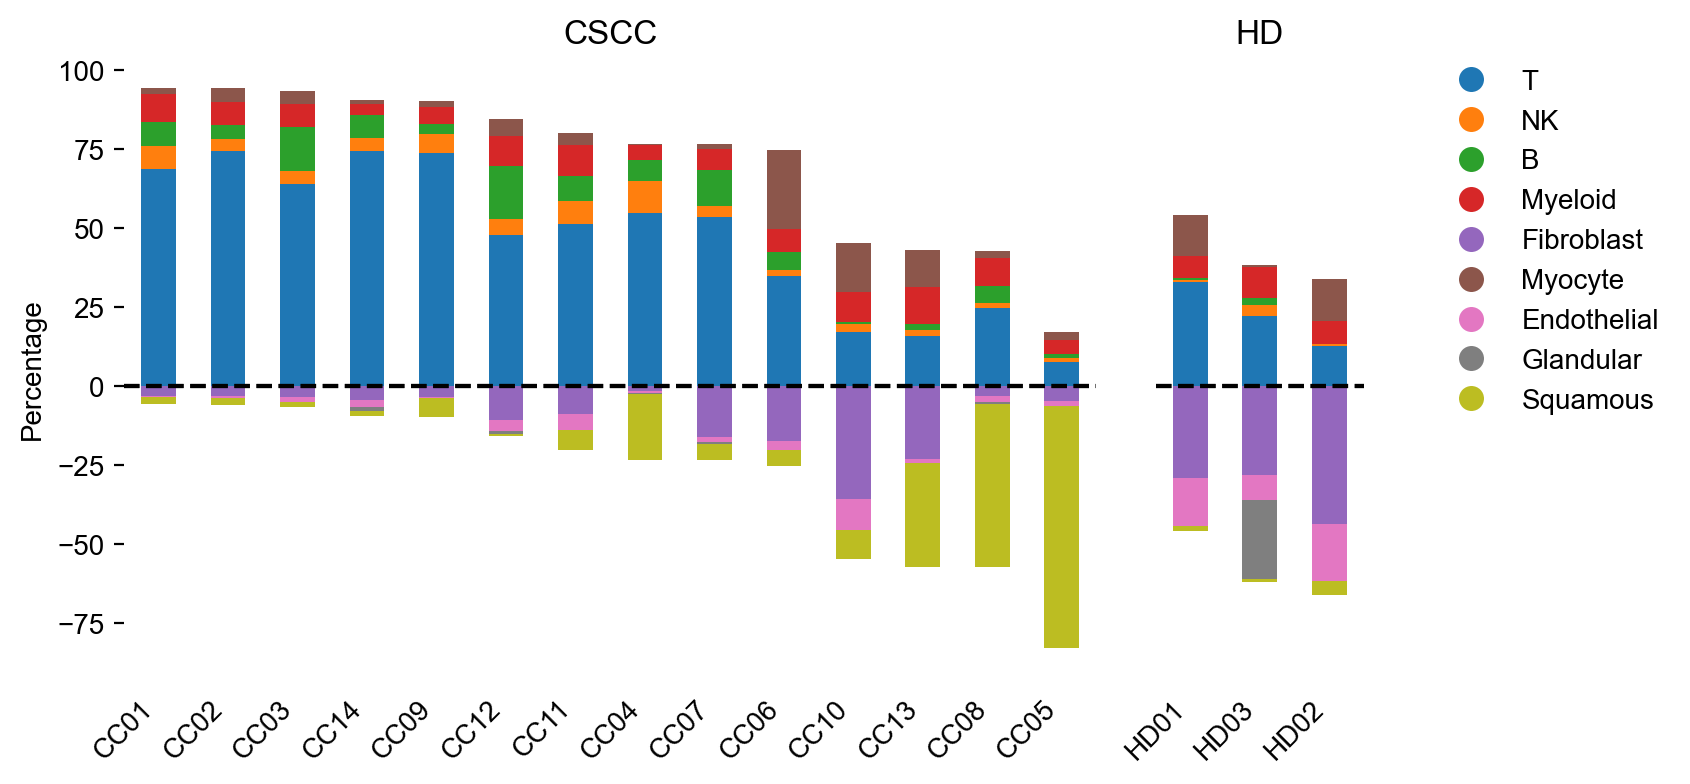

In [26]:
sctk.pl.percent_in_cluster_group(
    adata,
    groupby='sample', key='cell_type_l1',
    subgroups=subgroups, subkeys=subkeys,
    label_order='immune'
)

2024-05-27 20:03:54.540 | DEBUG    | sctk.pl.plotcluster:_plot_grouped_bars:250 - width_ratios=[17]


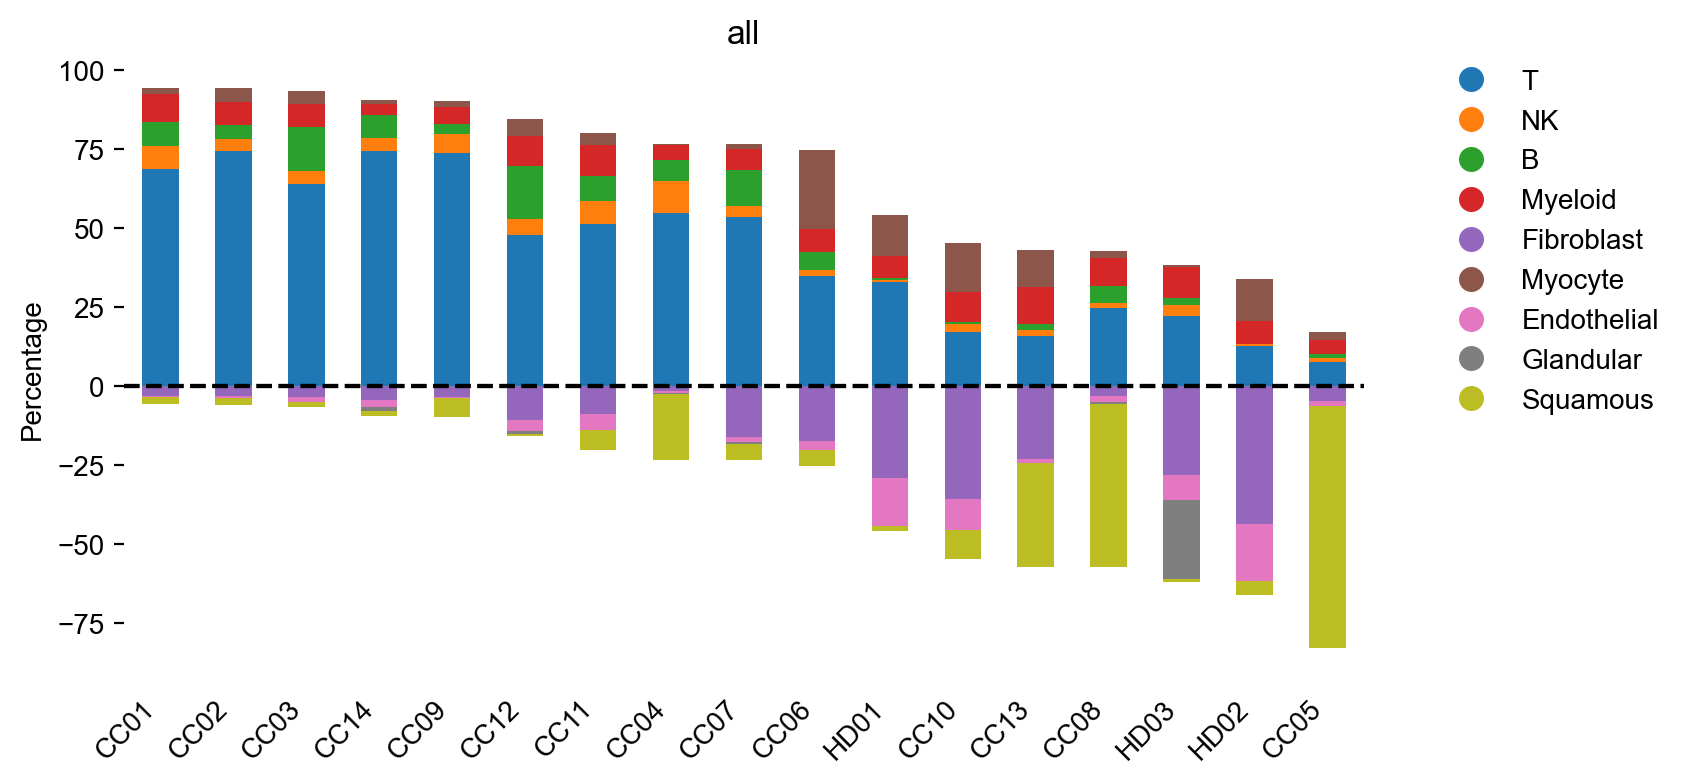

In [27]:
sctk.pl.percent_in_cluster_group(
    adata,
    groupby='sample', key='cell_type_l1', 
    subkeys=subkeys,
    label_order='immune', 
    subtitle=True
)

2024-05-27 20:04:09.811 | DEBUG    | sctk.pl.plotcluster:_plot_grouped_bars:250 - width_ratios=[17]


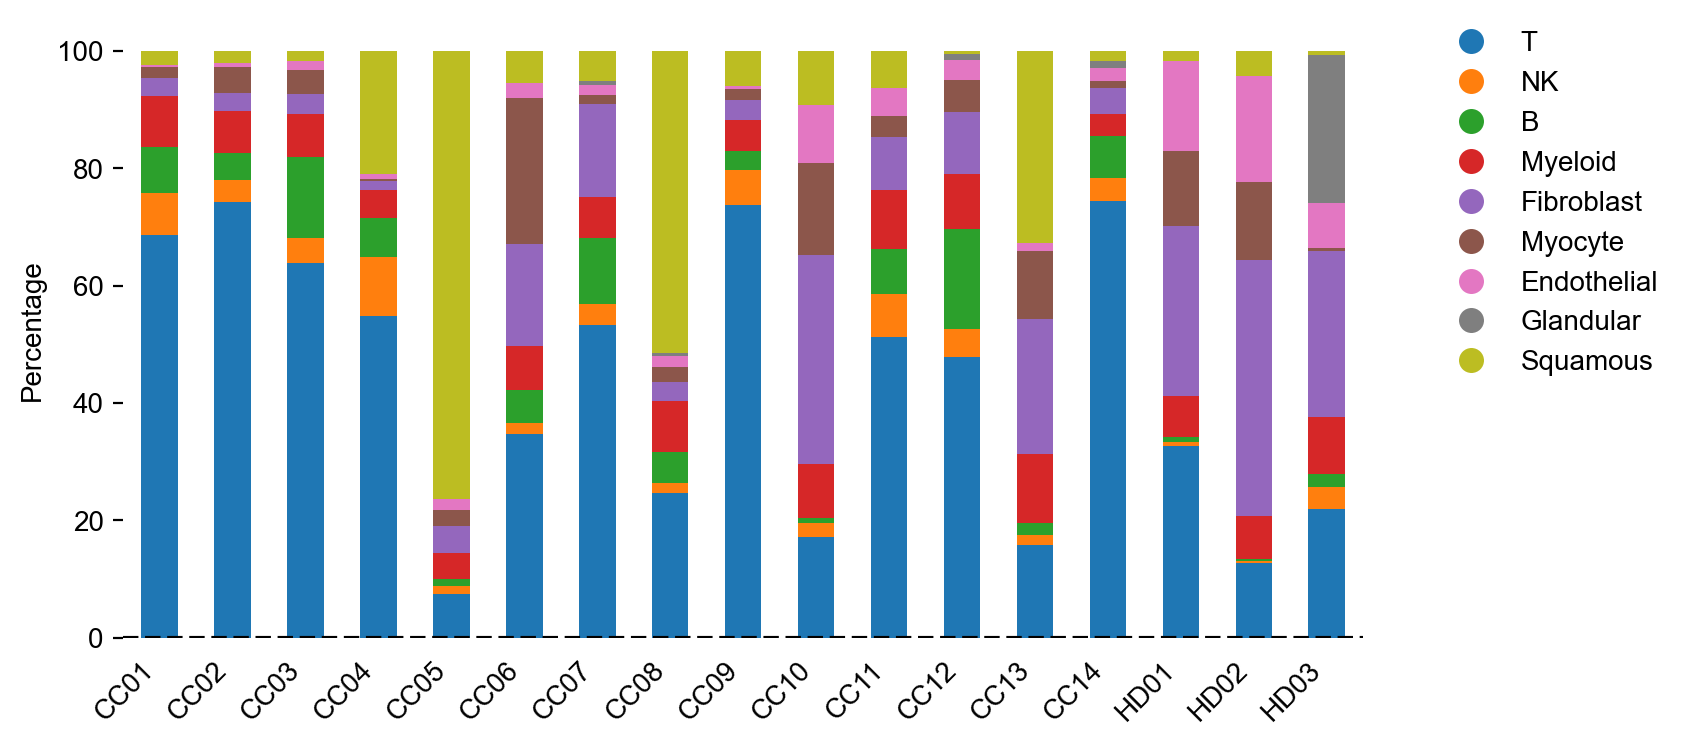

In [28]:
sctk.pl.percent_in_cluster_group(
    adata,
    groupby='sample', key='cell_type_l1',
    subtitle=False
)